# Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

# Discussing the topic

In this homework we have a mission to build a DecisionTreeClassifier using only bare hands. <br>
Steps for our implementation:
1. Classes for Node and Leaf in a tree
2. Functions for computing gain information while iterating nodes
3. Defining crucial parameters for tree classifier
4. Methods for fit and predict the results

Also, we might need to validate on current data, so it is better for us to recall some metrics like *accuracy*, *precision*, *recall* and *f-score*. Btw, the last one testing system is using to check predictions.

# Building Decision Tree Classifier

### 1. Classes for Node and Leaf in a tree

Leaf class represents the last node in each branch in a tree. So when we divide our dataset we usually stop in a leaf, where we know what the samples of data are and every row refers to some class. The majority of samples that have similar class we call an answer of our algorithm. <br>

So, for these reasons we need to store counts of values for given samples and the most likely class.

In [2]:
class DecisionTreeLeaf:
    def __init__(self, array):
        self.y = None
        self.v = array.value_counts(normalize=True)

        if len(self.v.index):
            self.y = self.v.index[0]
        self.d = {key: val for key, val in zip(self.v.index, self.v.values)}

When we are staying in the node we need to decide where to go: left path or right. The decision is relying on feature and value, that gives the highest information gain in splitting. So in order to help us find the best feature for split we need to define functions.

For Node class we will store feature, its value, the links for the left and right child.

In [3]:
class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

###  2. Functions for computing gain information. Gini and Entropy.

Statistic functions use only arrays of data and all calculations are based on statistic estimation for probabilities to be related to one particular class. In this task we will use Gini and Entropy. Gain  function represents how much information we get when split samples in a node.

In [4]:
def gini(x):
    probs = x.value_counts(normalize=True) ** 2
    return 1 - probs.sum()
    
def entropy(x):
    probs = x.value_counts(normalize=True)
    p_logp = probs * (np.log2(probs))
    return -p_logp.sum()

def gain(df, feat, val, criterion):
    if not df.shape[0]:
        return 0
    left = df.loc[df[feat] < val]
    right = df.loc[df[feat] >= val]
    return criterion(df['y']) - (left.shape[0] / df.shape[0] * criterion(left['y'])
                           + right.shape[0] / df.shape[0] * criterion(right['y']))

### 3-4. Parameters and methods for the tree.

Firstly we need to understand what attributes would be useful for the tree. We need a root, where we start iteration, we need a tree, where the nodes are stored. Also, we need model parameters such as maximum tree depth and minimum value for sample leaves, so we would know when to stop iteration.

Methods:
- Fitting the tree is finding the best split in each node: so we will store gaining values for several splits and choose the feature with the maximum gain. We have to build the function which is able to search best split, also we will need recursive function for visiting every node.
- For predicting labels for the foreign data our tree should have method that assigns labels for every new observations and give this prediction probability.

In [5]:
class DecisionTreeClassifier:
    def __init__(self, criterion, max_depth=3, min_samples_leaf=15):
        self.root = None
        self.tree = []
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    
    
    def fit(self, X, y):
        def best_split(df):
            df_for_splits = pd.DataFrame()
            for col in tqdm(df.drop('y', axis=1).columns):
                vals_for_split = np.linspace(df[col].min(), df[col].max(), num = 7)
                
                feat_split_df = pd.DataFrame()
                feat_split_df['vals_for_split'] = vals_for_split
                feat_split_df['feature'] = col

                feat_split_df['gain_by_criterion'] = feat_split_df['vals_for_split']. \
                    apply(lambda v: gain(df, col, v, gini))

                df_for_splits = pd.concat([df_for_splits, feat_split_df])

            df_for_splits.sort_values('gain_by_criterion', ascending=False, inplace=True)
            best_row = df_for_splits.iloc[0]

            feature_name, splitting_val = best_row['feature'], best_row['vals_for_split']
            
            return feature_name, splitting_val

        def split_rec(tree, df, max_depth, min_samples_leaf):
            if max_depth == 0 or df.shape[0] < min_samples_leaf or df['y'].value_counts(normalize=True).max() == 1:
                node = DecisionTreeLeaf(df['y'])
                return node

            feat_for_split, value_for_split = best_split(df)

            max_depth -= 1
            
            df_left = df.loc[df[feat_for_split] < value_for_split]
            df_right = df.loc[df[feat_for_split] >= value_for_split]

            node = DecisionTreeNode(feat_for_split, value_for_split, 
                                    split_rec(tree, df_left, max_depth, min_samples_leaf), 
                                    split_rec(tree, df_right, max_depth, min_samples_leaf))
            tree.append(node)
            return node

        df = pd.concat([X, y], axis=1)
        self.root = split_rec(self.tree, df, self.max_depth, self.min_samples_leaf)
        
    
    def predict_proba(self, X):
        proba_df = pd.DataFrame(X.index, columns=['ind'])
        proba_dict, pred_dict = {}, {}

        def sift_down(X, root, proba_dict, pred_dict):
            if isinstance(root, DecisionTreeNode):
                X_left = X.loc[X[root.split_dim] < root.split_value]
                sift_down(X_left, root.left, proba_dict, pred_dict)

                X_right = X.loc[X[root.split_dim] >= root.split_value]
                sift_down(X_right, root.right, proba_dict, pred_dict)
            else:
                for i in X.index:
                    proba_dict[i] = root.d
                    pred_dict[i] = root.y

        sift_down(X, self.root, proba_dict, pred_dict)
        proba_df['pair'] = proba_df['ind'].map(proba_dict)
        proba_df['pred'] = proba_df['ind'].map(pred_dict)

        return proba_df
            
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return proba['pred']


# Fitting on the train data 

In [6]:
X = pd.read_csv('data/x_spam_train.csv').drop('Id', axis=1)
y = pd.read_csv('data/y_spam_train.csv').drop('Id', axis=1)

y.rename({"Expected": 'y'}, inplace=True, axis=1)

### Validation on given data

In the last homework we defined function for splitting dataset in train and test subsets, also we defined a function that is able to compute needed metrics.

In [7]:
def train_test_split(X, y, ratio=0.6, seed=17):
    np.random.seed(seed)
    
    # finding the size of train and test
    train_size = int(X.shape[0] * ratio)
    
    train_idx = np.random.choice(X.index, size = train_size, replace=False)
    test_idx = [x for x in X.index if x not in train_idx]
    
    return X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

Testing system uses f1-score, so it is wise to validate using this metric as well. In our case we have 	$\beta = 1$

In [8]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://habrastorage.org/getpro/habr/post_images/4f1/f5c/0ab/4f1f5c0ab5dcf8379ff4bcbbd02f0623.svg")

In [9]:
def print_precision_recall_accuracy_f(y_pred, y_true, main_class):
    def get_stats(y_pred, y_true, value):
        TP = FP = FN = TN = 0
        for i in range(y_pred.shape[0]):
            if y_pred[i] == value and y_true[i] == value:
                TP +=1
            elif y_pred[i] != value and y_true[i] == value:
                FN += 1
            elif y_pred[i] == value and y_true[i] != value:
                FP += 1
            else:
                TN += 1
    
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)

        accuracy = (TP + TN) / (TP + FP + FN + TN)
        f1 = 2 * precision * recall / (precision + recall)
        return precision, recall, accuracy, f1

    prec, rec, acc, f1 = get_stats(y_pred, y_true, main_class)
    
    print('Precision: {:.3f}\nRecall: {:.3f}\nAccuracy: {:.3f}\nF1-score: {:.3f}'.format(prec, rec, acc, f1))

### Split on train and test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
print(X_train.shape, X_test.shape)
X_train.head(2)

(2208, 57) (1472, 57)


,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
3107,0.00,0.00,1.58,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.400,0.0,0.000,0.601,0.000,3.360,13.0,84.0
735,0.34,0.42,0.25,0.0,0.08,0.42,0.08,0.25,0.08,1.63,...,0.0,0.0,0.063,0.0,0.287,0.223,0.079,3.314,62.0,537.0


### Building simple classifier 

For the baseline let's build short tree and see the results.

In [12]:
clf1 = DecisionTreeClassifier(gini, max_depth=3)

clf1.fit(X_train, y_train)

100%|██████████| 57/57 [00:01<00:00, 45.99it/s]


Simple model fits pretty fast!

Validating on train and check metric values

In [13]:
y_pred1 = clf1.predict(X_test)

print_precision_recall_accuracy_f(y_pred1, y_test.reset_index()['y'], main_class=1)

Precision: 0.671
Recall: 0.792
Accuracy: 0.776
F1-score: 0.726


Even simple short tree gives us pretty good results. Obviously we can tune some model parameters, but we will do that later. For now let's draw our small tree.

Function for drawing nodes and leaves.

In [14]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (int(tree_root.split_dim), tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree_root, save_path='./tree1.png'):
    td = tree_depth(tree_root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree_root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

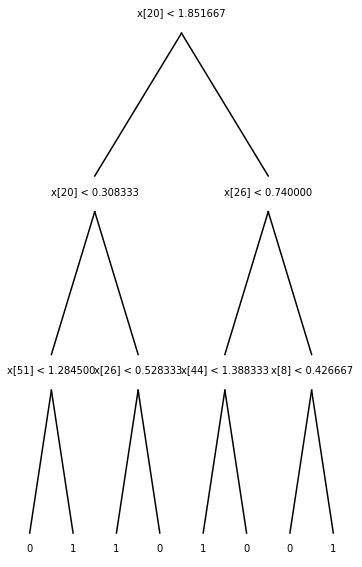

In [15]:
draw_tree(clf1.root, './clf1_tree')

Okay, we see that our tree might be underfitted, because we have ~50 features and this model uses only 6 for splitting. In the next subsection we will intuitively increase the max_depth parameter. But for more academic approach we should use something like GridSearch.

### Building more complex classifier

In [16]:
clf2 = DecisionTreeClassifier(gini, max_depth=5)

clf2.fit(X_train, y_train)

100%|██████████| 57/57 [00:01<00:00, 45.97it/s]


Oh! This model learned a bit longer, since we gave it more freedom for going deeper. Let's hope the results will be better on validation

In [17]:
y_pred2 = clf2.predict(X_test)

print_precision_recall_accuracy_f(y_pred2, y_test.reset_index()['y'], main_class=1)

Precision: 0.756
Recall: 0.819
Accuracy: 0.833
F1-score: 0.786


Yep, all metrics are higher. Let's draw decision tree for classifier 2.

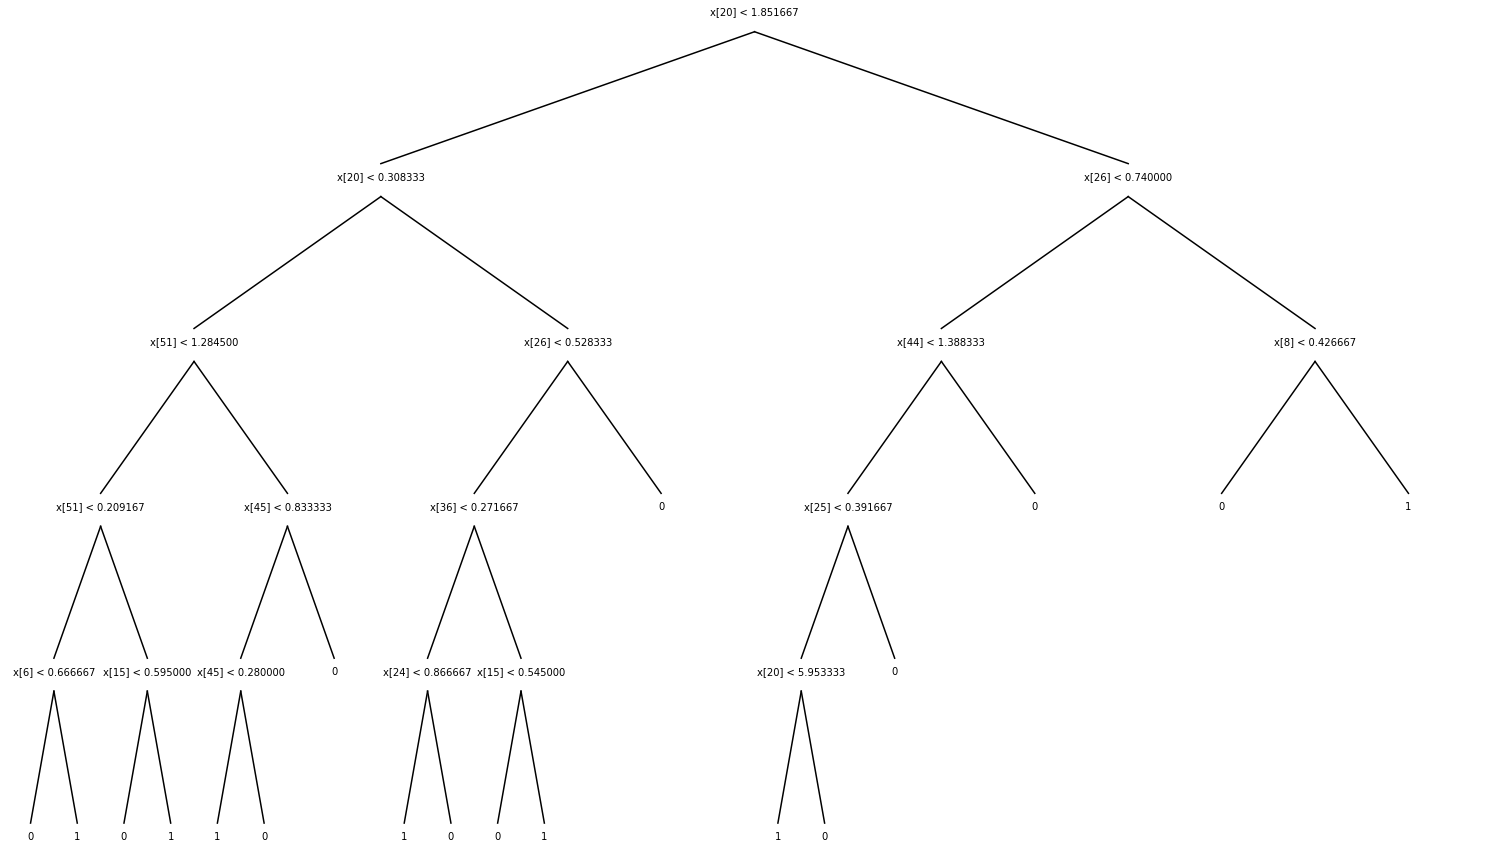

In [18]:
draw_tree(clf2.root, './clf2_tree')

In [19]:
print('Number of features used: {}'.format(len(set([node.split_dim for node in clf2.tree]))))

Number of features used: 11


It is obvious that tuning parameters is crucial part of fitting the model, but in this case our goal was to implement working implementation for the Decision Tree Classifier, in my opinion we did great job here.

# Comparing results with KNN model

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
knn = KNeighborsClassifier(7)

knn.fit(X_train, y_train['y'])

KNeighborsClassifier(n_neighbors=7)

In [22]:
y_pred_knn = knn.predict(X_test)

print('KNN results:')
print_precision_recall_accuracy_f(y_pred_knn, y_test.reset_index()['y'], main_class=1)
print('------------')
print_precision_recall_accuracy_f(y_pred2, y_test.reset_index()['y'], main_class=1)

KNN results:
Precision: 0.721
Recall: 0.685
Accuracy: 0.782
F1-score: 0.703
------------
Precision: 0.756
Recall: 0.819
Accuracy: 0.833
F1-score: 0.786


We see that metric shows us worse results compare to decision tree classifier. Let's try to discuss what are the benefits to use knn or decision tree for the classification problem.

1. KNN model works only with numeric data, so if given data has categorical features we need to process them in order to fit the model.
2. KNN is "lazy learner", since it starts computing only when test data is provided. So if we have data streams it is good, but on large datasets the ide of recomputing is bad.
3. Yet again, on large datasets `n_neighbors` parameter is usually >150, so it is complicated to interpret.
4. Also, KNN relates to the fact, that it has "curse of dimensionality". If there are a lot of features KNN will not perform well.

Decision tree also has pros and cons:

1. It is well design for human interpretation: if income of a given person > 300.000$/sec, then it is SW/ML engineer and so on.
2. Once it is fitted, predictions for new data could be built. Tree needs time to be built, but the process of making predictions is fast.
3. Decision tree can split in each node for both numeric and categorical features.
4. However, the tree is not stable for noise and changing in data: the whole tree might be rearranged.
5. Decision tree predictions rely on what the model see in training set, so it can only interpolate.

<br>
Taking it into consideration in my opinion it is easier and more effecient to predict using decision tree. Possible values of hyper parametrs are not that high, fast learning and predciting, good understanding for me as a coder on what is under the hood. Also KNN works worse with the large amount of features, in this case we have ~50, so decision tree is our best choice.
